In [14]:
import tensorflow as tf
import os
from os.path import exists
from tensorflow.python.keras.models import load_model
import pandas as pd
import joblib
import loadingbar
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [15]:
# ignore warning for assigning entire column to a scalar value
pd.set_option('mode.chained_assignment', None)

In [16]:
os.chdir('C:/Users/zacha/Documents/GitHub/plymouth-university-proj518')
print(os.getcwd())

C:\Users\zacha\Documents\GitHub\plymouth-university-proj518


In [17]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [18]:
model_path = os.path.join(os.getcwd(), 'saved_models', 'wind_time_regression_model_25_08_2022_12_44_03.h5')

if exists(model_path):  # load model if exists
    print(f"LOADING MODEL: {model_path}")
    model = load_model(model_path)
else:
    raise Exception("NO MODEL FOUND")

model.summary()

# load wind model input scaler
scaler_path = os.path.join(os.getcwd(), 'saved_models', 'wind_time_scaler_25_08_2022_11_21_49')

scaler = joblib.load(scaler_path)

LOADING MODEL: C:\Users\zacha\Documents\GitHub\plymouth-university-proj518\saved_models\wind_time_regression_model_25_08_2022_12_44_03.h5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_5 (Dense)              (None, 64)           

In [19]:
df = pd.read_csv('data/2020 velocity potential .995 sigma.csv')    # read file to get world lat lon sample coords

days=(0, 228+1)
days_list = [str(i) for i in range(days[0], days[1])]
filedata = pd.DataFrame(columns=['Lon', 'Lat', *days_list])

L = loadingbar.PercentageInfoLoadingBar(days[1])

# fill lat lon datapoints in filedata with df values
filedata['Lon'] = df['Lon']
filedata['Lat'] = df['Lat']

X = filedata[['Lon', 'Lat']]

# iterate through each row in dataframe
for day in range(days[0], days[1]):
    L.update(1)

    # set day to current day for all rows
    X['Day'] = day

    # predict in batches (per file)
    regression = model.predict(X)
    regression = scaler.inverse_transform(regression)  # transform back to original scale

    regression = pd.DataFrame(regression, columns=[str(day)])  # convert predictions to dataframe with column name = day

    # we can add the predictions to the filedata dataframe without reference to lat/lon, as order is retained
    filedata[str(day)] = regression[str(day)] # add predictions to filedata

L.done()

██████████████████████████████████████████████████%     0K    0K/s  7sec                                                                                                      


██████████████████████████████████████████████████%     0K    0K/s  0sec                                                                                                      


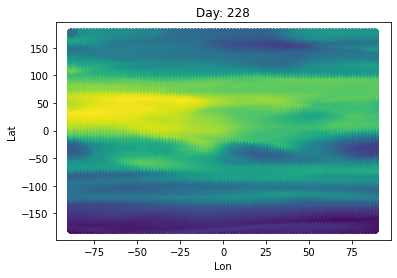

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax.set_title("Day: 0")

ax.scatter(filedata['Lon'], filedata['Lat'], c=filedata['0'], cmap='viridis')

L = loadingbar.PercentageInfoLoadingBar(days[1])

def update(i):
    L.update(1)

    if i > 228:
        i = 0
    
    ax.clear()
    ax.collections.clear()

    ax.set_xlabel('Lon')
    ax.set_ylabel('Lat')

    ax.set_title(f"Day: {i}")

    ax.scatter(filedata['Lon'], filedata['Lat'], c=filedata[str(i)], cmap='viridis')

ani = animation.FuncAnimation(fig, update, frames=days[1], interval=100, blit=False)
ani.save("NCEP 2022 velocity potential reanalysis prediction 2.gif", writer="imagemagick")

L.done()